In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import glob
import nibabel as nb
import itertools
import json
import sys
import statsmodels.api as sm
from statsmodels.formula.api import ols

from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder


%matplotlib inline

In [2]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [3]:
base_dir = '/home/abhijit/Jyotirmay/my_thesis'
proj = 'MC_dropout_quicknat'
model = 'v2'
dataset = 'KORA'
report_id = '10_1572006141.7793334'
sample_dir = f'{base_dir}/projects/{proj}/outs/{proj}_{dataset}_{model}/{proj}_{dataset}_{model}_predictions_{dataset}/*_samples/**'
mean_segs_dir = f'{base_dir}/projects/{proj}/outs/{proj}_{dataset}_{model}/{proj}_{dataset}_{model}_predictions_{dataset}/*_seg.nii.gz'
sample_paths = glob.glob(sample_dir)
mean_seg_paths = glob.glob(mean_segs_dir)
print(len(mean_seg_paths))
sample_paths.extend(mean_seg_paths)
print(len(sample_paths))

153
1683


In [4]:
sample_count_dict = {}
for r_id, sample in enumerate(sample_paths):
    print("\rProcessing {}/{}.".format(r_id, len(sample_paths)), end="")

    split_str = sample.split('/')[-1].split('.')[0]
    v_id = split_str.split('_')[0]
    sample_id = split_str.split('_')[-1]
    s_data = nb.load(sample).get_fdata()
    unique_vals, counts = np.unique(s_data, return_counts=True)
    if v_id not in sample_count_dict.keys():
        sample_count_dict[v_id] = {str(i)+'_spleen':None for i in range(10)}
        sample_count_dict[v_id].update({str(i)+'_liver':None for i in range(10)})
    if sample_id == 'seg':
        sample_count_dict[v_id]['seg_spleen'] = counts[2]
        sample_count_dict[v_id]['seg_liver'] = counts[1]
    else:
        sample_count_dict[v_id][str(sample_id)+'_liver'] = counts[2]    
        sample_count_dict[v_id][str(sample_id)+'_spleen'] = counts[1] 

print(sample_count_dict)
df = pd.DataFrame.from_dict(sample_count_dict, orient="index")
df.to_csv(f'./projects/{proj}/reports/{proj}_{dataset}_{model}/{dataset}/{report_id}_sample_count_report.csv', index_label='volume_id')


Processing 1682/1683.{'KORA2452967': {'0_spleen': 12927, '1_spleen': 12821, '2_spleen': 12712, '3_spleen': 12593, '4_spleen': 12708, '5_spleen': 12700, '6_spleen': 12718, '7_spleen': 12814, '8_spleen': 12914, '9_spleen': 12654, '0_liver': 110718, '1_liver': 111393, '2_liver': 111419, '3_liver': 111048, '4_liver': 110701, '5_liver': 111706, '6_liver': 110756, '7_liver': 110737, '8_liver': 110599, '9_liver': 110966, 'seg_spleen': 110450, 'seg_liver': 12769}, 'KORA2459526': {'0_spleen': 20711, '1_spleen': 20395, '2_spleen': 20661, '3_spleen': 20698, '4_spleen': 20588, '5_spleen': 20535, '6_spleen': 20709, '7_spleen': 20717, '8_spleen': 20430, '9_spleen': 20399, '0_liver': 170056, '1_liver': 169671, '2_liver': 169688, '3_liver': 169249, '4_liver': 170064, '5_liver': 169745, '6_liver': 169932, '7_liver': 169946, '8_liver': 169662, '9_liver': 169695, 'seg_spleen': 169665, 'seg_liver': 20596}, 'KORA2455268': {'0_spleen': 7322, '1_spleen': 7018, '2_spleen': 7057, '3_spleen': 6963, '4_spleen': 

In [5]:
df = pd.read_csv(f'./projects/{proj}/reports/{proj}_{dataset}_{model}/{dataset}/{report_id}_sample_count_report.csv')

In [6]:
# df_k_feats = pd.read_csv('./dataset_groups/whole_body_datasets/KORA/processsed_csv.csv')
# df_k_feats['volume_id'] = 'KORA' + df_k_feats['mrt-image-id'].astype(str)
# df_k_feats.to_csv('./dataset_groups/whole_body_datasets/KORA/processsed_csv_.csv')
df_k_feats = pd.read_csv('./dataset_groups/whole_body_datasets/KORA/processsed_csv_.csv')

In [7]:
df_reports = pd.read_csv(f'./projects/{proj}/reports/{proj}_{dataset}_{model}/{dataset}/{report_id}_report.csv')

In [8]:
df_merged = pd.merge(df, df_k_feats, how='inner', on=['volume_id'])
df_merged_final = pd.merge(df_merged, df_reports, how='inner', on=['volume_id'])
df_merged_final.to_csv(f'./projects/{proj}/reports/{proj}_{dataset}_{model}/{dataset}/{report_id}_concat_report_final.csv')

In [9]:
df = pd.read_csv(f'./projects/{proj}/reports/{proj}_{dataset}_{model}/{dataset}/{report_id}_concat_report_final.csv')

In [10]:
good_feats = ['bmi-who_normal', 'bmi-who_obesity class I', 'bmi-who_obesity class II', 'bmi-who_obesity class III',
             'hba1c-mmol/mol', 'cholesterol-hdl', 'age', 'blood-pressure-diastolic', 'blood-pressure-systolic',
             'sex', 'bmi-numeric']

smoking_feats = ['smoker_former', 'smoker_irregular', 'smoker_non-smoker', 'smoker_regular', 'smoking-packages']
bmi_feats = ['bmi-who_normal', 'bmi-who_obesity class I', 'bmi-who_obesity class II', 'bmi-who_obesity class III',
            'bmi-numeric', 'bmi-who_pre-obisety']
blood_pressure_feats = ['blood-pressure-diastolic', 'blood-pressure-systolic']
cholesterol_feats = ['cholesterol-hdl', 'cholesterol-ldl', 'cholesterol-total']
mri_feats = ['mri-liver-fat-artifacts', 'mri-liver-fat-lobus-dexter', 
             'mri-liver-fat-lobus-sinister', 'mri-liver-fat-portal-vein']
alcohol_feats = ['alcohol-g/day']
hbalc_feats = ['hba1c-mmol/mol', 'hba1c-percentage']
medication_feats = ['meds-antidiabetic', 'meds-antihypertensive', 'meds-incretin-mimetics', 'meds-insulin-therapy',
                    'meds-lipoprotein-lowering', 'meds-oral-antidiabetic']
triglyceride = ['triglyceride']
hypertension = ['hypertension']
basic_feats = ['age', 'height', 'sex', 'weight' ]
vols_feat = ['seg_liver', 'seg_spleen']

In [37]:
all_feats = [basic_feats, smoking_feats, bmi_feats, blood_pressure_feats, cholesterol_feats, 
             mri_feats, alcohol_feats, hbalc_feats, medication_feats, triglyceride, hypertension, vols_feat]
feats = flatten(all_feats)
df = df.fillna(0)
p_values = {}
y = df["diabetes_status"].copy()
y_classes = np.argmax(pd.get_dummies(y).values, axis=1)
# print(y_classes, pd.get_dummies(y).values)
for f in feats:
    try:
        X = pd.get_dummies(df.loc[y.index, [f]], drop_first=True)
#         X = X.fillna(0)
        mod = sm.OLS(y_classes, X)
        fii = mod.fit()
#         print(fii.summary())
#         print(f, fii.pvalues.values[0])
        p_values[f] = {'coeff': fii.params.values[0], 'p_value':fii.pvalues.values[0]}
    except Exception as e:
        print(e)
p_value_df = pd.DataFrame.from_dict(p_values, orient="index")
p_value_df

,coeff,p_value
age,0.008857,1.232938e-15
height,0.002735,8.371145e-14
sex,0.615385,4.480111e-14
weight,0.006076,5.552860e-17
smoker_former,0.514706,1.934475e-07
smoker_irregular,0.333333,2.394919e-01
smoker_non-smoker,0.423077,2.523419e-04
smoker_regular,0.500000,3.555895e-03
smoking-packages,0.014308,1.977551e-05
bmi-who_normal,0.190476,1.460153e-01


In [13]:

p_value_df.to_csv(f'./projects/{proj}/reports/{proj}_{dataset}_{model}/{dataset}/{report_id}_p_values.csv', index_label='feats')
        

In [14]:
categorical_features = ['diabetes_status']
for f in categorical_features:
    dfDummies = pd.get_dummies(df[f], prefix = f)
    df_c = pd.concat([df, dfDummies], axis=1)

In [15]:
all_feats4vols = [basic_feats, smoking_feats, bmi_feats, blood_pressure_feats, cholesterol_feats, 
             mri_feats, alcohol_feats, hbalc_feats, medication_feats, triglyceride, hypertension,
                  ['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2']]

feats = flatten(all_feats4vols)
df_c = df_c.fillna(0)
p_values = {}
y = df_c["seg_spleen"].copy()
y_classes = y.values #np.argmax(pd.get_dummies(y).values, axis=1)
for f in feats:
    try:
        X = pd.get_dummies(df_c.loc[y.index, [f]], drop_first=True)
#         X = X.fillna(0)
        mod = sm.OLS(y_classes, X)
        fii = mod.fit()
#         print(fii.summary())
#         print(f, fii.pvalues.values[0], fii.params.values)
        p_values[f] = {'coeff': fii.params.values[0], 'p_value':fii.pvalues.values[0]}
    except Exception as e:
        print(e)

# print(p_values)
p_value_df = pd.DataFrame.from_dict(p_values, orient="index")
p_value_df

,coeff,p_value
age,2412.747212,2.307646e-78
height,810.725505,1.357957e-102
sex,151472.285714,2.528856e-38
weight,1662.481395,1.607278e-127
smoker_former,141643.000000,1.039832e-20
smoker_irregular,132422.000000,5.048947e-03
smoker_non-smoker,135179.673077,1.197484e-13
smoker_regular,140980.250000,5.357600e-07
smoking-packages,4174.350904,2.171445e-15
bmi-who_normal,115468.285714,4.406447e-08


In [16]:
all_feats4vols = [basic_feats, smoking_feats, bmi_feats, blood_pressure_feats, cholesterol_feats, 
             mri_feats, alcohol_feats, hbalc_feats, medication_feats, triglyceride, hypertension,
                  ['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2']]

feats = flatten(all_feats4vols)
df_c = df_c.fillna(0)
p_values = {}
y = df_c["seg_liver"].copy()
y_classes = y.values #np.argmax(pd.get_dummies(y).values, axis=1)
for f in feats:
    try:
        X = pd.get_dummies(df_c.loc[y.index, [f]], drop_first=True)
#         print(X)
#         X = X.fillna(0)
        mod = sm.OLS(y_classes, X)
        fii = mod.fit()
#         print(fii.summary())
#         print(f, fii.pvalues.values[0], fii.params.values)
        p_values[f] = {'coeff': fii.params.values[0], 'p_value':fii.pvalues.values[0]}
    except Exception as e:
        print(e)

# print(p_values)
p_value_df = pd.DataFrame.from_dict(p_values, orient="index")
p_value_df

,coeff,p_value
age,297.850649,6.668983e-54
height,100.531423,1.284803e-63
sex,19213.824176,6.809412e-34
weight,208.748567,8.081661e-75
smoker_former,18588.161765,1.436758e-20
smoker_irregular,17471.000000,4.932667e-03
smoker_non-smoker,16485.442308,1.226313e-11
smoker_regular,14549.541667,1.099485e-04
smoking-packages,538.189104,1.044772e-14
bmi-who_normal,12536.666667,8.884132e-06


In [38]:
# all_feats4vols = [basic_feats, smoking_feats, bmi_feats, blood_pressure_feats, cholesterol_feats, 
#              mri_feats, alcohol_feats, hbalc_feats, medication_feats, triglyceride, hypertension, ['diabetes_status']]

mod_s = []
all_feats_simple = [['age', 'sex'],['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2'],['height', 'weight']]
all_feats_simple1 = [['age', 'sex'],['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2'],['bmi-numeric']]
all_feats_simple2 = [['age', 'sex'],['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2'],['height', 'weight', 'bmi-numeric']]
all_feats_simple3 = [['diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2']]
for feats_list in [all_feats_simple1]:
    feats = flatten(feats_list)
    df_c = df_c.fillna(0)
    p_values = {}
    for target in ['seg_liver', 'seg_spleen']:
 
        for i in range(2):
            print(target) 
            y = df_c[target].copy()
    #         print(y.values)
    #         y_classes = np.argmax(pd.get_dummies(y).values, axis=1)
            y_classes = y.values
            if i==0:
                continue
                print('iou as multiplier')
                target_prefix = target.split('_')[1]
                ious = df_c['iou_'+target_prefix].values
#                 print(y_classes[0:10], ious[0:10])
                y_classes = np.multiply(y_classes, ious)
#                 print(y_classes[0:10])
    #         print(y_classes)
            try:
                print(feats)
                X = pd.get_dummies(df_c.loc[y.index, feats], drop_first=True)
            #         X = X.fillna(0)
                mod = sm.OLS(y_classes, X)
                mod_ = ols("y_classes ~ X", df_c).fit()
                mod_s.append(mod_)
                table = sm.stats.anova_lm(mod_) # Type 2 Anova DataFrame
                print('------------------------------------------------------------')
                print(table)
                fii = mod.fit()
                print(fii.summary())
                df_fii = pd.read_html(fii.summary().tables[1].as_html(),header=0,index_col=0)[0]
#                 print(df_fii)
            #         print(f, fii.pvalues.values[0], fii.params.values)
                p_values[f] = {'coeff': fii.params.values, 'p_value':fii.pvalues.values}
            except Exception as e:
                print(e)

# full_table = sm.stats.anova_lm(mod_s) # Type 2 Anova DataFrame
# print(full_table)
# print(p_values)
# p_value_df = pd.DataFrame.from_dict(p_values, orient="index")
# p_value_df

seg_liver
seg_liver
['age', 'sex', 'diabetes_status_0', 'diabetes_status_1', 'diabetes_status_2', 'bmi-numeric']
------------------------------------------------------------
             df        sum_sq       mean_sq          F        PR(>F)
X           6.0  2.854994e+09  4.758323e+08  11.517405  1.526094e-10
Residual  147.0  6.073186e+09  4.131419e+07        NaN           NaN
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     13.75
Date:                Mon, 28 Oct 2019   Prob (F-statistic):           5.14e-11
Time:                        11:29:07   Log-Likelihood:                -1555.6
No. Observations:                 153   AIC:                             3123.
Df Residuals:                     147   BIC:                      

In [19]:
l = df_c.columns.values
l[29] = 'bmi_numeric'
df_c.columns = l
df_c.columns

Index(['Unnamed: 0', 'volume_id', '0_spleen', '1_spleen', '2_spleen',
       '3_spleen', '4_spleen', '5_spleen', '6_spleen', '7_spleen', '8_spleen',
       '9_spleen', '0_liver', '1_liver', '2_liver', '3_liver', '4_liver',
       '5_liver', '6_liver', '7_liver', '8_liver', '9_liver', 'seg_spleen',
       'seg_liver', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'age', 'alcohol-g/day',
       'blood-pressure-diastolic', 'bmi_numeric', 'bmi-numeric', 'bmi-who',
       'cholesterol-hdl', 'cholesterol-ldl', 'cholesterol-total',
       'diabetes_status', 'hba1c-mmol/mol', 'hba1c-percentage', 'height',
       'hypertension', 'meds-antidiabetic', 'meds-antihypertensive',
       'meds-incretin-mimetics', 'meds-insulin-therapy',
       'meds-lipoprotein-lowering', 'meds-oral-antidiabetic',
       'mri-liver-fat-artifacts', 'mri-liver-fat-lobus-dexter',
       'mri-liver-fat-lobus-sinister', 'mri-liver-fat-portal-vein',
       'mrt-image-id', 'sex', 'smoker', 'smoking-packages', 'triglyceride',
       'wei

In [20]:
mod_liver = ols('seg_liver ~ age + sex + bmi_numeric + diabetes_status_0 + diabetes_status_1 + diabetes_status_2'
           , df_c).fit()
mod_spleen = ols('seg_spleen ~ age + sex + bmi_numeric + diabetes_status_0 + diabetes_status_1 + diabetes_status_2'
           , df_c).fit()

In [21]:

full_table = sm.stats.anova_lm(mod_liver) # Type 2 Anova DataFrame
print(full_table)

                      df        sum_sq       mean_sq          F    PR(>F)
age                  1.0  2.370949e+08  2.370949e+08   4.600782  0.033601
sex                  1.0  9.362500e+08  9.362500e+08  18.167759  0.000036
bmi_numeric          1.0  8.245519e+07  8.245519e+07   1.600028  0.207901
diabetes_status_0    1.0  6.719567e+07  6.719567e+07   1.303920  0.255355
diabetes_status_1    1.0  1.558114e+07  1.558114e+07   0.302349  0.583248
diabetes_status_2    1.0  7.211228e+06  7.211228e+06   0.139933  0.708887
Residual           147.0  7.575439e+09  5.153360e+07        NaN       NaN


In [22]:

full_table = sm.stats.anova_lm(mod_spleen) # Type 2 Anova DataFrame
print(full_table)

                      df        sum_sq       mean_sq          F        PR(>F)
age                  1.0  1.015864e+10  1.015864e+10  16.752708  6.997354e-05
sex                  1.0  3.614893e+10  3.614893e+10  59.613555  1.637516e-12
bmi_numeric          1.0  2.201742e+10  2.201742e+10  36.309149  1.293653e-08
diabetes_status_0    1.0  1.294327e+10  1.294327e+10  21.344879  8.316610e-06
diabetes_status_1    1.0  2.885911e+09  2.885911e+09   4.759184  3.073139e-02
diabetes_status_2    1.0  3.226916e+08  3.226916e+08   0.532154  4.668635e-01
Residual           147.0  8.913900e+10  6.063878e+08        NaN           NaN


In [23]:
df_normal = df[df['diabetes_status']==0]
df_pre_diabetic = df[df['diabetes_status']==1]
df_diabetic = df[df['diabetes_status']==2]

Text(0, 0.5, 'Dice Score')

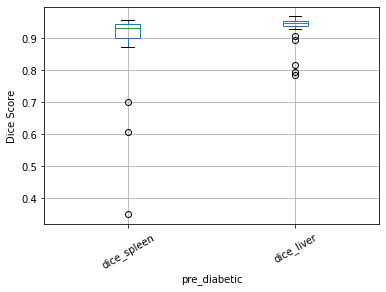

In [24]:
boxplot = df_pre_diabetic[['dice_spleen', 'dice_liver']].boxplot(rot=30)
boxplot.set_xlabel("pre_diabetic")
boxplot.set_ylabel("Dice Score")

Text(0, 0.5, 'Dice Score')

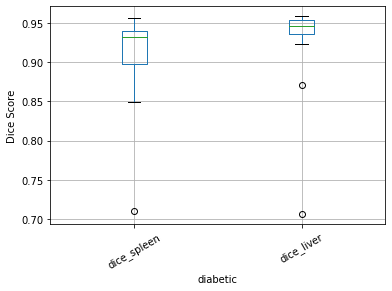

In [25]:
boxplot = df_diabetic[['dice_spleen', 'dice_liver']].boxplot(rot=30)
boxplot.set_xlabel("diabetic")
boxplot.set_ylabel("Dice Score")

Text(0, 0.5, 'Dice Score')

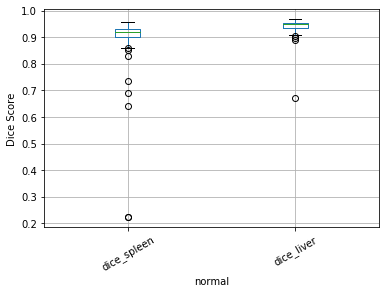

In [26]:
boxplot = df_normal[['dice_spleen', 'dice_liver']].boxplot(rot=30)
boxplot.set_xlabel("normal")
boxplot.set_ylabel("Dice Score")

In [27]:

df_normal_affx = df_normal.rename(columns=lambda x: 'normal_'+x)
df_pre_diabetic_affx = df_pre_diabetic.rename(columns=lambda x: 'pre_diabetic_'+x)
df_diabetic_affx = df_diabetic.rename(columns=lambda x: 'diabetic_'+x)
dfs = pd.concat([df_normal_affx, df_pre_diabetic_affx, df_diabetic_affx])

/home/abhijit/anaconda3/envs/tenv/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


normal_dice_spleen vs pre_diabetic_dice_spleen
t: 0.036397424468365594
p: 0.9710204533214777


normal_dice_spleen vs diabetic_dice_spleen
t: -0.6062452494458419
p: 0.5455263480426604


pre_diabetic_dice_spleen vs diabetic_dice_spleen
t: -0.5530536371479056
p: 0.582642981122792


normal_dice_liver vs pre_diabetic_dice_liver
t: 1.1609200454901425
p: 0.24776957413052658


normal_dice_liver vs diabetic_dice_liver
t: 1.2577046159759966
p: 0.21100308071592597


pre_diabetic_dice_liver vs diabetic_dice_liver
t: 0.23751271212504196
p: 0.8132106367146477




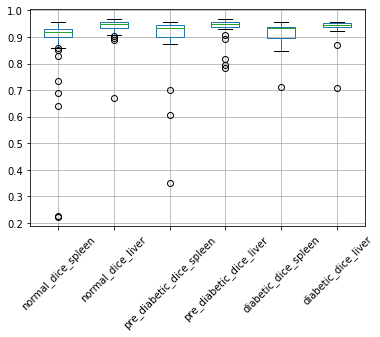

In [28]:
dfs[['normal_dice_spleen', 'normal_dice_liver', 'pre_diabetic_dice_spleen', 'pre_diabetic_dice_liver', 'diabetic_dice_spleen', 'diabetic_dice_liver']].boxplot(rot=45)

t,p = stats.ttest_ind(dfs['normal_dice_spleen'].dropna().values, dfs[ 'pre_diabetic_dice_spleen'].dropna().values)
print('normal_dice_spleen vs pre_diabetic_dice_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_dice_spleen'].dropna().values, dfs[ 'diabetic_dice_spleen'].dropna().values)
print('normal_dice_spleen vs diabetic_dice_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_dice_spleen'].dropna().values, dfs[ 'diabetic_dice_spleen'].dropna().values)
print('pre_diabetic_dice_spleen vs diabetic_dice_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_dice_liver'].dropna().values, dfs[ 'pre_diabetic_dice_liver'].dropna().values)
print('normal_dice_liver vs pre_diabetic_dice_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_dice_liver'].dropna().values, dfs[ 'diabetic_dice_liver'].dropna().values)
print('normal_dice_liver vs diabetic_dice_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_dice_liver'].dropna().values, dfs[ 'diabetic_dice_liver'].dropna().values)
print('pre_diabetic_dice_liver vs diabetic_dice_liver')
print('t:', t)
print('p:', p)
print('\n')

normal_iou_spleen vs pre_diabetic_iou_spleen
t: -0.5924542205250573
p: 0.554560000280409


normal_iou_spleen vs diabetic_iou_spleen
t: -0.03974358689138806
p: 0.9683652900579374


pre_diabetic_iou_spleen vs diabetic_iou_spleen
t: 0.3269955417874664
p: 0.745009604274016


normal_iou_liver vs pre_diabetic_iou_liver
t: 1.4109248169907014
p: 0.16061925105153346


normal_iou_liver vs diabetic_iou_liver
t: 2.720633664471421
p: 0.007510232644655195


pre_diabetic_iou_liver vs diabetic_iou_liver
t: 0.8543849218961339
p: 0.3968873844302878




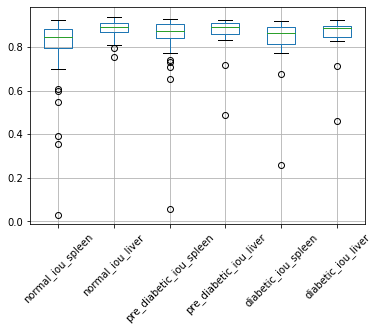

In [29]:
dfs[['normal_iou_spleen', 'normal_iou_liver', 'pre_diabetic_iou_spleen', 'pre_diabetic_iou_liver', 'diabetic_iou_spleen', 'diabetic_iou_liver']].boxplot(rot=45)

t,p = stats.ttest_ind(dfs['normal_iou_spleen'].dropna().values, dfs[ 'pre_diabetic_iou_spleen'].dropna().values)
print('normal_iou_spleen vs pre_diabetic_iou_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_iou_spleen'].dropna().values, dfs[ 'diabetic_iou_spleen'].dropna().values)
print('normal_iou_spleen vs diabetic_iou_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_iou_spleen'].dropna().values, dfs[ 'diabetic_iou_spleen'].dropna().values)
print('pre_diabetic_iou_spleen vs diabetic_iou_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_iou_liver'].dropna().values, dfs[ 'pre_diabetic_iou_liver'].dropna().values)
print('normal_iou_liver vs pre_diabetic_iou_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_iou_liver'].dropna().values, dfs[ 'diabetic_iou_liver'].dropna().values)
print('normal_iou_liver vs diabetic_iou_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_iou_liver'].dropna().values, dfs[ 'diabetic_iou_liver'].dropna().values)
print('pre_diabetic_iou_liver vs diabetic_iou_liver')
print('t:', t)
print('p:', p)
print('\n')

normal_surface_distance_prtogt_spleen vs pre_diabetic_surface_distance_prtogt_spleen
t: 0.07738934967149264
p: 0.9384309956961456


normal_surface_distance_prtogt_spleen vs diabetic_surface_distance_prtogt_spleen
t: 0.07024585926713481
p: 0.9441178992356375


pre_diabetic_surface_distance_prtogt_spleen vs diabetic_surface_distance_prtogt_spleen
t: 0.003704274203225902
p: 0.9970588754396199


normal_surface_distance_prtogt_liver vs pre_diabetic_surface_distance_prtogt_liver
t: 1.337747278083722
p: 0.18327906364339494


normal_surface_distance_prtogt_liver vs diabetic_surface_distance_prtogt_liver
t: 1.1540610184368134
p: 0.2508270583201849


pre_diabetic_surface_distance_prtogt_liver vs diabetic_surface_distance_prtogt_liver
t: -0.06811927694421895
p: 0.9459570567878764




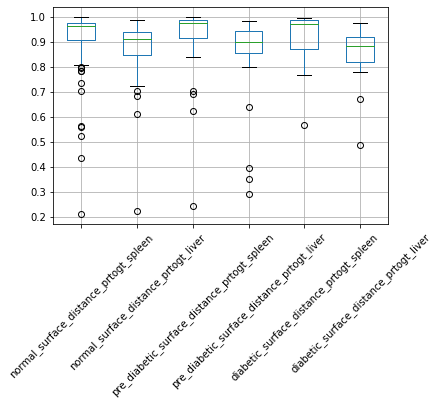

In [30]:
dfs[['normal_surface_distance_prtogt_spleen', 'normal_surface_distance_prtogt_liver', 'pre_diabetic_surface_distance_prtogt_spleen', 'pre_diabetic_surface_distance_prtogt_liver', 'diabetic_surface_distance_prtogt_spleen', 'diabetic_surface_distance_prtogt_liver']].boxplot(rot=45)

t,p = stats.ttest_ind(dfs['normal_surface_distance_prtogt_spleen'].dropna().values, dfs[ 'pre_diabetic_surface_distance_prtogt_spleen'].dropna().values)
print('normal_surface_distance_prtogt_spleen vs pre_diabetic_surface_distance_prtogt_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_surface_distance_prtogt_spleen'].dropna().values, dfs[ 'diabetic_surface_distance_prtogt_spleen'].dropna().values)
print('normal_surface_distance_prtogt_spleen vs diabetic_surface_distance_prtogt_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_surface_distance_prtogt_spleen'].dropna().values, dfs[ 'diabetic_surface_distance_prtogt_spleen'].dropna().values)
print('pre_diabetic_surface_distance_prtogt_spleen vs diabetic_surface_distance_prtogt_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_surface_distance_prtogt_liver'].dropna().values, dfs[ 'pre_diabetic_surface_distance_prtogt_liver'].dropna().values)
print('normal_surface_distance_prtogt_liver vs pre_diabetic_surface_distance_prtogt_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_surface_distance_prtogt_liver'].dropna().values, dfs[ 'diabetic_surface_distance_prtogt_liver'].dropna().values)
print('normal_surface_distance_prtogt_liver vs diabetic_surface_distance_prtogt_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_surface_distance_prtogt_liver'].dropna().values, dfs[ 'diabetic_surface_distance_prtogt_liver'].dropna().values)
print('pre_diabetic_surface_distance_prtogt_liver vs diabetic_surface_distance_prtogt_liver')
print('t:', t)
print('p:', p)
print('\n')

normal_surface_distance_gttopr_spleen vs pre_diabetic_surface_distance_gttopr_spleen
t: 0.42584039756283576
p: 0.6709176837621199


normal_surface_distance_gttopr_spleen vs diabetic_surface_distance_gttopr_spleen
t: -0.31214657714482275
p: 0.7554847383992287


pre_diabetic_surface_distance_gttopr_spleen vs diabetic_surface_distance_gttopr_spleen
t: -0.478250564837262
p: 0.6345156730744678


normal_surface_distance_gttopr_liver vs pre_diabetic_surface_distance_gttopr_liver
t: 1.1139394908881728
p: 0.2673293756650863


normal_surface_distance_gttopr_liver vs diabetic_surface_distance_gttopr_liver
t: 0.3318159081359987
p: 0.7406219276645054


pre_diabetic_surface_distance_gttopr_liver vs diabetic_surface_distance_gttopr_liver
t: -0.4448025562270379
p: 0.6583445225508145




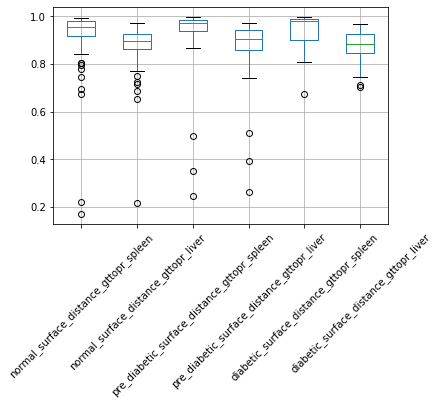

In [31]:
dfs[['normal_surface_distance_gttopr_spleen', 'normal_surface_distance_gttopr_liver', 'pre_diabetic_surface_distance_gttopr_spleen', 'pre_diabetic_surface_distance_gttopr_liver', 'diabetic_surface_distance_gttopr_spleen', 'diabetic_surface_distance_gttopr_liver']].boxplot(rot=45)

t,p = stats.ttest_ind(dfs['normal_surface_distance_gttopr_spleen'].dropna().values, dfs[ 'pre_diabetic_surface_distance_gttopr_spleen'].dropna().values)
print('normal_surface_distance_gttopr_spleen vs pre_diabetic_surface_distance_gttopr_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_surface_distance_gttopr_spleen'].dropna().values, dfs[ 'diabetic_surface_distance_gttopr_spleen'].dropna().values)
print('normal_surface_distance_gttopr_spleen vs diabetic_surface_distance_gttopr_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_surface_distance_gttopr_spleen'].dropna().values, dfs[ 'diabetic_surface_distance_gttopr_spleen'].dropna().values)
print('pre_diabetic_surface_distance_gttopr_spleen vs diabetic_surface_distance_gttopr_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_surface_distance_gttopr_liver'].dropna().values, dfs[ 'pre_diabetic_surface_distance_gttopr_liver'].dropna().values)
print('normal_surface_distance_gttopr_liver vs pre_diabetic_surface_distance_gttopr_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_surface_distance_gttopr_liver'].dropna().values, dfs[ 'diabetic_surface_distance_gttopr_liver'].dropna().values)
print('normal_surface_distance_gttopr_liver vs diabetic_surface_distance_gttopr_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_surface_distance_gttopr_liver'].dropna().values, dfs[ 'diabetic_surface_distance_gttopr_liver'].dropna().values)
print('pre_diabetic_surface_distance_gttopr_liver vs diabetic_surface_distance_gttopr_liver')
print('t:', t)
print('p:', p)
print('\n')

normal_surface_distance_avg_spleen vs pre_diabetic_surface_distance_avg_spleen
t: 0.2652880565869812
p: 0.7912014126739236


normal_surface_distance_avg_spleen vs diabetic_surface_distance_avg_spleen
t: -0.12091868481223204
p: 0.9039628586886204


diabetic_surface_distance_avg_spleen vs pre_diabetic_surface_distance_avg_spleen
t: 0.25681786358973724
p: 0.7983526350322211


normal_surface_distance_avg_liver vs pre_diabetic_surface_distance_avg_liver
t: 1.2497966898384338
p: 0.21358518242755029


normal_surface_distance_avg_liver vs diabetic_surface_distance_avg_liver
t: 0.7917773257536656
p: 0.43009285337073955


diabetic_surface_distance_avg_liver vs pre_diabetic_surface_distance_avg_liver
t: 0.24800610872575668
p: 0.8051255412817141




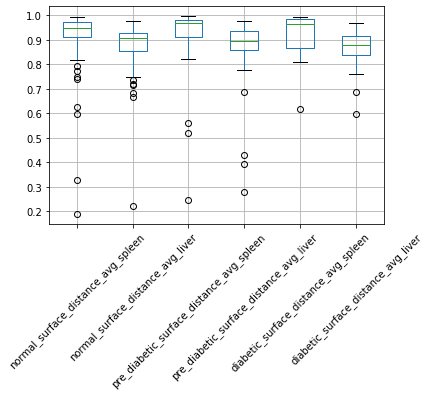

In [32]:
dfs[['normal_surface_distance_avg_spleen', 'normal_surface_distance_avg_liver', 'pre_diabetic_surface_distance_avg_spleen', 'pre_diabetic_surface_distance_avg_liver', 'diabetic_surface_distance_avg_spleen', 'diabetic_surface_distance_avg_liver']].boxplot(rot=45)

t,p = stats.ttest_ind(dfs['normal_surface_distance_avg_spleen'].dropna().values, dfs[ 'pre_diabetic_surface_distance_avg_spleen'].dropna().values)

print('normal_surface_distance_avg_spleen vs pre_diabetic_surface_distance_avg_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_surface_distance_avg_spleen'].dropna().values, dfs[ 'diabetic_surface_distance_avg_spleen'].dropna().values)
print('normal_surface_distance_avg_spleen vs diabetic_surface_distance_avg_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['diabetic_surface_distance_avg_spleen'].dropna().values, dfs[ 'pre_diabetic_surface_distance_avg_spleen'].dropna().values)
print('diabetic_surface_distance_avg_spleen vs pre_diabetic_surface_distance_avg_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_surface_distance_avg_liver'].dropna().values, dfs[ 'pre_diabetic_surface_distance_avg_liver'].dropna().values)
print('normal_surface_distance_avg_liver vs pre_diabetic_surface_distance_avg_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_surface_distance_avg_liver'].dropna().values, dfs[ 'diabetic_surface_distance_avg_liver'].dropna().values)
print('normal_surface_distance_avg_liver vs diabetic_surface_distance_avg_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['diabetic_surface_distance_avg_liver'].dropna().values, dfs[ 'pre_diabetic_surface_distance_avg_liver'].dropna().values)
print('diabetic_surface_distance_avg_liver vs pre_diabetic_surface_distance_avg_liver')
print('t:', t)
print('p:', p)
print('\n')


normal_dice_mean vs pre_diabetic_dice_mean
t: 0.3329330081168737
p: 0.7397130473886646


normal_dice_mean vs diabetic_dice_mean
t: -0.11908574947504072
p: 0.9054116492509189


diabetic_dice_mean vs pre_diabetic_dice_mean
t: 0.34427537849462914
p: 0.7320547638952957




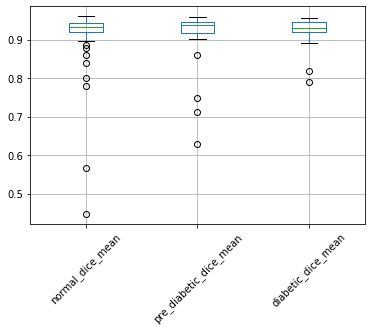

In [33]:
# dfs[['normal_iou_mean', 'normal_dice_mean', 'pre_diabetic_iou_mean', 'pre_diabetic_dice_mean', 'diabetic_iou_mean', 'diabetic_dice_mean']].boxplot(rot=45)
dfs[[ 'normal_dice_mean', 'pre_diabetic_dice_mean', 'diabetic_dice_mean']].boxplot(rot=45)

# dfs['normal_dice_mean'].dropna().values



t,p = stats.ttest_ind(dfs['normal_dice_mean'].dropna().values, dfs[ 'pre_diabetic_dice_mean'].dropna().values)

print('normal_dice_mean vs pre_diabetic_dice_mean')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_dice_mean'].dropna().values, dfs[ 'diabetic_dice_mean'].dropna().values)
print('normal_dice_mean vs diabetic_dice_mean')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['diabetic_dice_mean'].dropna().values, dfs[ 'pre_diabetic_dice_mean'].dropna().values)
print('diabetic_dice_mean vs pre_diabetic_dice_mean')
print('t:', t)
print('p:', p)
print('\n')


normal_ged vs pre_diabetic_ged
t: -0.33961809607527677
p: 0.7346839130850777


diabetic_ged vs pre_diabetic_ged
t: -0.3980352793959007
p: 0.6922655366140789


normal_ged vs diabetic_ged
t: 0.21446536968276955
p: 0.8305575131715038


normal_sncc vs pre_diabetic_sncc
t: 0.5853698001284287
p: 0.5592984886834318


normal_sncc vs diabetic_sncc
t: -2.9612685243776955
p: 0.00371075455115785


pre_diabetic_sncc vs diabetic_sncc
t: -2.568738051552546
p: 0.013176752150298593




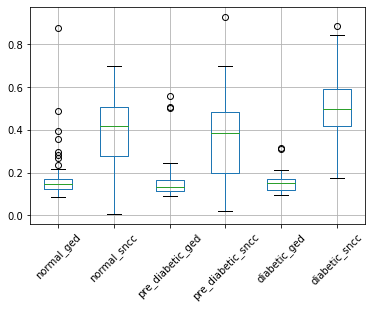

In [34]:
dfs[['normal_ged', 'normal_sncc', 'pre_diabetic_ged', 'pre_diabetic_sncc', 'diabetic_ged', 'diabetic_sncc']].boxplot(rot=45)

t,p = stats.ttest_ind(dfs['normal_ged'].dropna().values, dfs[ 'pre_diabetic_ged'].dropna().values)

print('normal_ged vs pre_diabetic_ged')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['diabetic_ged'].dropna().values, dfs[ 'pre_diabetic_ged'].dropna().values)
print('diabetic_ged vs pre_diabetic_ged')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_ged'].dropna().values, dfs[ 'diabetic_ged'].dropna().values)
print('normal_ged vs diabetic_ged')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_sncc'].dropna().values, dfs[ 'pre_diabetic_sncc'].dropna().values)
print('normal_sncc vs pre_diabetic_sncc')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_sncc'].dropna().values, dfs[ 'diabetic_sncc'].dropna().values)
print('normal_sncc vs diabetic_sncc')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['pre_diabetic_sncc'].dropna().values, dfs[ 'diabetic_sncc'].dropna().values)
print('pre_diabetic_sncc vs diabetic_sncc')
print('t:', t)
print('p:', p)
print('\n')

normal_seg_spleen vs pre_diabetic_seg_spleen
t: -3.606119741979465
p: 0.0004395222039744966


normal_seg_spleen vs diabetic_seg_spleen
t: -5.015670100846983
p: 1.9025008134471282e-06


diabetic_seg_spleen vs pre_diabetic_seg_spleen
t: 1.7455681642931289
p: 0.08690840071618669


normal_seg_liver vs pre_diabetic_seg_liver
t: -0.9536003162577149
p: 0.34202899734442027


normal_seg_liver vs diabetic_seg_liver
t: -1.605811038751021
p: 0.11101116816104598


diabetic_seg_liver vs pre_diabetic_seg_liver
t: 0.8918994201489261
p: 0.37663574282167345




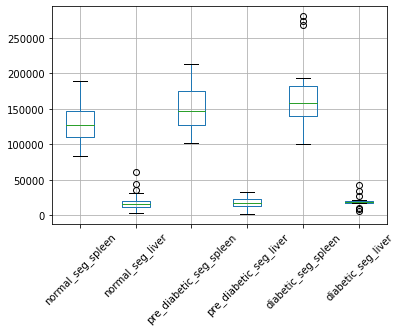

In [35]:
dfs[['normal_seg_spleen', 'normal_seg_liver', 'pre_diabetic_seg_spleen', 'pre_diabetic_seg_liver', 'diabetic_seg_spleen', 'diabetic_seg_liver']].boxplot(rot=45)

t,p = stats.ttest_ind(dfs['normal_seg_spleen'].dropna().values, dfs[ 'pre_diabetic_seg_spleen'].dropna().values)

print('normal_seg_spleen vs pre_diabetic_seg_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_seg_spleen'].dropna().values, dfs[ 'diabetic_seg_spleen'].dropna().values)
print('normal_seg_spleen vs diabetic_seg_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['diabetic_seg_spleen'].dropna().values, dfs[ 'pre_diabetic_seg_spleen'].dropna().values)
print('diabetic_seg_spleen vs pre_diabetic_seg_spleen')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_seg_liver'].dropna().values, dfs[ 'pre_diabetic_seg_liver'].dropna().values)
print('normal_seg_liver vs pre_diabetic_seg_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['normal_seg_liver'].dropna().values, dfs[ 'diabetic_seg_liver'].dropna().values)
print('normal_seg_liver vs diabetic_seg_liver')
print('t:', t)
print('p:', p)
print('\n')

t,p = stats.ttest_ind(dfs['diabetic_seg_liver'].dropna().values, dfs[ 'pre_diabetic_seg_liver'].dropna().values)
print('diabetic_seg_liver vs pre_diabetic_seg_liver')
print('t:', t)
print('p:', p)
print('\n')